# Demonstration of DCBC evaluation usage 
This notebook simulates the DCBC evaluation of a given cortical parcellation. 

## Installation and Requirments

Ensure Python version >= 3.6 and pip installed on your system.

- Install Python at https://www.python.org/downloads/
- Install pip: https://pip.pypa.io/en/stable/installing/

## Dependencies

`pip install nibabel scipy numpy sklearn matplotlib`

## Project structre

```
project/
│   README.md
│   eval_DCBC.py
│   plotting.py
│   sample.py
│   sample.ipynb
│
└───distanceMatrix/
│       disAvrg_sp.mat
│       ...
│   
└───parcellations/
│       └───random/
│       │       Icosahedron-42.32k.L.label.gii
│       │       ...
│       AAL.32k.L.label.gii
│       ...
│   
└───data/
        s02
        s03
	...
	s31
```

## Usage
Below is the sample script of using the DCBC evaluation

In [1]:
from eval_DCBC import DCBC
from plotting import plot_wb_curve
import nibabel as nb
import numpy as np

In [2]:
print('Start evaluating DCBC sample code ...')

# Load cortical parcellation from label.gii file
mat = nb.load('parcellations/Power2011.32k.L.label.gii')
parcels = [x.data for x in mat.darrays]
parcels = np.reshape(parcels, (len(parcels[0]),))

# Make sure the input parcels has a shape of (N,)
T = DCBC(hems='L', maxDist=35, binWidth=1).evaluate(parcels)

Start evaluating DCBC sample code ...


evaluating s02 L ...


evaluating s03 L ...


evaluating s04 L ...


evaluating s06 L ...


evaluating s08 L ...


evaluating s09 L ...


evaluating s10 L ...


evaluating s12 L ...


evaluating s14 L ...


evaluating s15 L ...


evaluating s17 L ...


evaluating s18 L ...


evaluating s19 L ...


evaluating s20 L ...


evaluating s21 L ...


evaluating s22 L ...


evaluating s24 L ...


evaluating s25 L ...


evaluating s26 L ...


evaluating s27 L ...


evaluating s28 L ...


evaluating s29 L ...


evaluating s30 L ...


evaluating s31 L ...


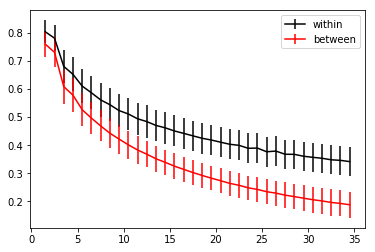

In [3]:
# Plotting the within/between curve
%matplotlib inline

plot_wb_curve(T, path='data', hems='L')